In [1]:
# Import modules
import numpy as np
import pandas as pd
pd.options.display.max_columns = 1000
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# Read excel file, display sheet names
xl = pd.ExcelFile('DataSet/ICNALE_Infosheet_201912.xlsx')
xl.sheet_names

['Spoken Monologue_2.0',
 'Spoken Dialogue_1.1',
 'Written Essays_2.4',
 'Edited Essays_2.1']

In [3]:
# Read in dataframe from Written Essays 2.4 sheet
df = pd.read_excel('DataSet/ICNALE_Infosheet_201912.xlsx', sheet_name = 'Written Essays_2.4')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Code                 2800 non-null   object 
 1   Country              2800 non-null   object 
 2   PTJ1 (wds)           2800 non-null   int64  
 3   PTJ2 (wds)           0 non-null      float64
 4   SMK1 (wds)           2800 non-null   int64  
 5   SMK2 (wds)           0 non-null      float64
 6   Self Ev              0 non-null      float64
 7   Sex                  2800 non-null   object 
 8   Age                  2800 non-null   int64  
 9   Grade/Degree         2474 non-null   float64
 10  Yrs of Stay (< Yrs)  0 non-null      float64
 11  ENS Type             200 non-null    object 
 12  Major/ Occupation    2669 non-null   object 
 13  Acad. Genre          2569 non-null   object 
 14  Test                 1499 non-null   object 
 15  Score                1499 non-null   o

In [5]:
df.columns

Index(['Code', 'Country', 'PTJ1 (wds)', 'PTJ2 (wds)', 'SMK1 (wds)',
       'SMK2 (wds)', 'Self Ev', 'Sex', 'Age', 'Grade/Degree',
       'Yrs of Stay (< Yrs)', 'ENS Type', 'Major/ Occupation', 'Acad. Genre',
       'Test', 'Score', 'VST', 'CEFR', 'INTM', 'INSM', 'INTM+INSM',
       'INTM-INSM', 'Primary', 'Secondary', 'College', 'Inschool', 'Outschool',
       'Listening', 'Reading', 'Speaking', 'Writing', 'NS', 'Pronunciation',
       'Presentation', 'EssayW'],
      dtype='object')

In [6]:
df.Country.unique()

array(['CHN', 'ENS_AUS', 'ENS_GBR', 'ENS_NZL', 'ENS_USA', 'ENS_CAN',
       'HKG', 'IDN', 'JPN', 'KOR', 'PAK', 'PHL', 'SIN', 'THA', 'TWN'],
      dtype=object)

In [7]:
# English speaking countries are not of interest and are missing most data. Exclude them from df.
eng_countries = ['ENS_AUS', 'ENS_GBR', 'ENS_NZL', 'ENS_USA', 'ENS_CAN']
df = df[~df.Country.isin(eng_countries)]

In [8]:
df.shape

(2600, 35)

In [9]:
# Many columns are either completely or nearly empty. Drop them. 
# Also INTM+INSM and INTM-INSM are (by definition) linear combinations of INTM and INSM. Drop these too.
df = df.drop(['PTJ2 (wds)', 'SMK2 (wds)', 'Self Ev', 'Yrs of Stay (< Yrs)', 'ENS Type', 'INTM+INSM', 'INTM-INSM'], axis=1)

In [10]:
# Print out number of unique entries per feature to get a feel for the data.
temp = {}
for c in df.columns:
    temp[c] = df[c].nunique()
pd.DataFrame(temp.values(), index=temp.keys(), columns=['# unique'])

,# unique
Code,2600
Country,10
PTJ1 (wds),157
SMK1 (wds),150
Sex,7
Age,18
Grade/Degree,7
Major/ Occupation,136
Acad. Genre,4
Test,20


In [11]:
# Some features are either awkwardly named and/or difficult to type out - simplify them.
df = df.rename(columns={'PTJ1 (wds)':'PTJ1', 'SMK1 (wds)':'SMK1', 'Grade/Degree':'Grade', 'Major/ Occupation':'Major', 'Acad. Genre':'Field'})

In [12]:
# Percentage of isna's per column
round(df.isna().sum()/df.shape[0]*100, 2)

Code              0.00
Country           0.00
PTJ1              0.00
SMK1              0.00
Sex               0.00
Age               0.00
Grade             4.85
Major             4.00
Field             4.00
Test             42.35
Score            42.35
VST               0.00
CEFR              0.00
INTM             12.08
INSM             12.08
Primary          12.04
Secondary        12.04
College          12.04
Inschool         12.04
Outschool        12.04
Listening        12.04
Reading          12.04
Speaking         12.04
Writing          12.04
NS               12.04
Pronunciation    12.04
Presentation     12.04
EssayW           12.04
dtype: float64

In [13]:
df.dtypes

Code              object
Country           object
PTJ1               int64
SMK1               int64
Sex               object
Age                int64
Grade            float64
Major             object
Field             object
Test              object
Score             object
VST              float64
CEFR              object
INTM             float64
INSM             float64
Primary          float64
Secondary        float64
College          float64
Inschool         float64
Outschool        float64
Listening        float64
Reading          float64
Speaking         float64
Writing          float64
NS                object
Pronunciation     object
Presentation      object
EssayW            object
dtype: object

In [14]:
# Some numeric columns are of the wrong data type. Coerce them to numeric type.
num_cols = ['Score', 'NS', 'Pronunciation', 'Presentation', 'EssayW']

for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [15]:
df.Sex.unique()

array(['F', 'M', 'M ', 'F ', 'm', 'f', ' F'], dtype=object)

In [16]:
# Correct/unify gender typos.
df.Sex = df.Sex.replace(['F ', 'f', ' F'], 'F')
df.Sex = df.Sex.replace(['M ', 'm'],'M')

In [17]:
df.Sex.unique()

array(['F', 'M'], dtype=object)

In [18]:
df.isna().sum()

Code                0
Country             0
PTJ1                0
SMK1                0
Sex                 0
Age                 0
Grade             126
Major             104
Field             104
Test             1101
Score            1319
VST                 0
CEFR                0
INTM              314
INSM              314
Primary           313
Secondary         313
College           313
Inschool          313
Outschool         313
Listening         313
Reading           313
Speaking          313
Writing           313
NS                314
Pronunciation     314
Presentation      314
EssayW            314
dtype: int64

In [19]:
# Handle missing Grade information. Also this is likely better suited as ordinal variable, not continuous. Convert to str.
df.Grade = df.Grade.fillna(0)
df.Grade.unique()

array([2., 3., 1., 4., 0., 7., 5., 6.])

In [20]:
# Fill missing Majors and Fields with N/A's.
df.Major = df.Major.fillna('N/A')
df.Field = df.Field.fillna('N/A')

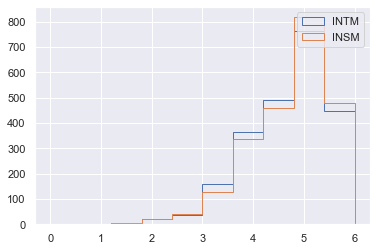

In [21]:
# Show distribution of motivation scores to get a feel for how to handle missing data.
sns.set()
_ = plt.hist(df.INTM, histtype='step', label='INTM')
_ = plt.hist(df.INSM, histtype='step', label='INSM')
plt.legend()
plt.show()

In [22]:
# Distribution is suspiciously similar. Check their correlation to see how highly correlated they are.
df.INTM.corr(df.INSM)

0.4398844705406561

In [23]:
df.INTM.median(), df.INSM.median(), df.INTM.mean(), df.INSM.mean()

(4.83, 4.83, 4.705170603674543, 4.7484558180227445)

In [24]:
# Uncorrelated enough to keep both, and median/mean both seem like decent estimators to the missing values. Fillna w/ them.
df.INTM = df.INTM.fillna(df.INTM.median())
df.INSM = df.INSM.fillna(df.INSM.median())

In [25]:
df.columns

Index(['Code', 'Country', 'PTJ1', 'SMK1', 'Sex', 'Age', 'Grade', 'Major',
       'Field', 'Test', 'Score', 'VST', 'CEFR', 'INTM', 'INSM', 'Primary',
       'Secondary', 'College', 'Inschool', 'Outschool', 'Listening', 'Reading',
       'Speaking', 'Writing', 'NS', 'Pronunciation', 'Presentation', 'EssayW'],
      dtype='object')

3.0 3.1464801049409705


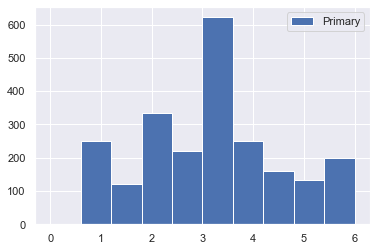

3.75 3.733170091823371


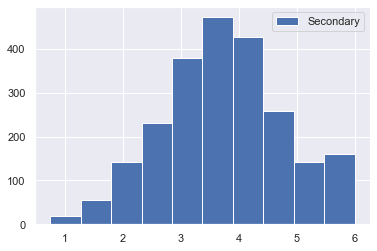

4.25 4.1426934849147115


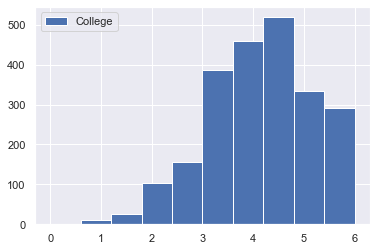

4.11 4.0908395277656355


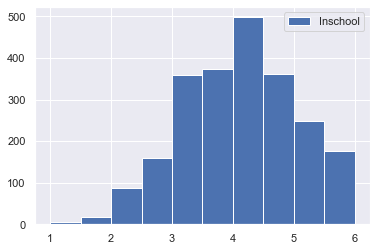

3.56 3.605452557936166


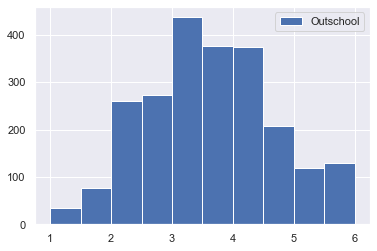

4.25 4.141123742894622


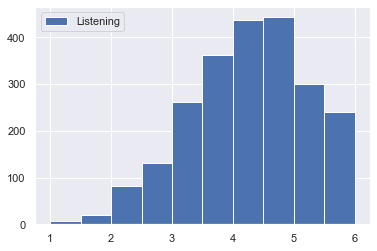

4.25 4.1815697420201134


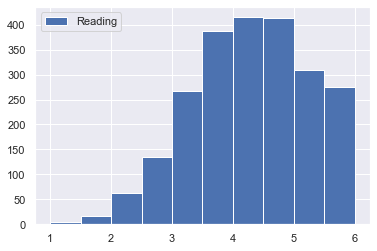

3.5 3.5860297332750326


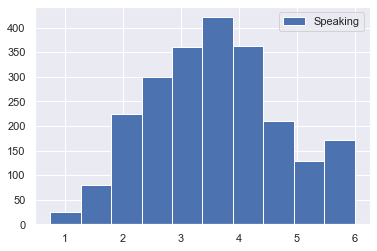

3.75 3.834643637953651


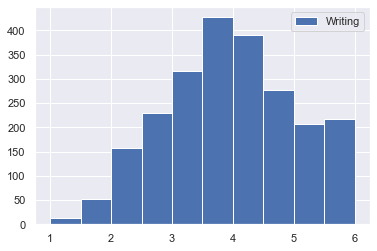

4.0 3.984251968503937


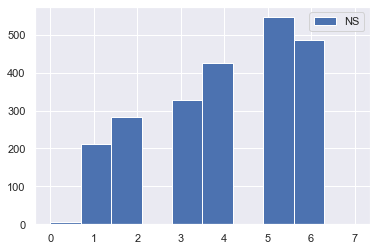

5.0 4.278652668416448


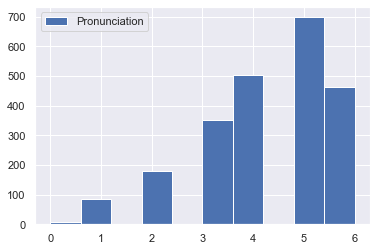

4.0 4.268153980752406


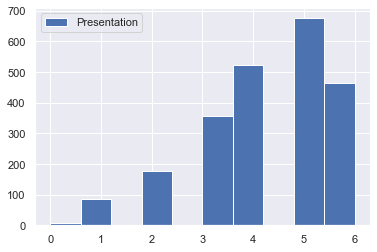

5.0 4.229221347331584


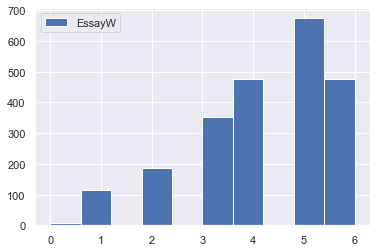

In [26]:
# For a similar exercise with the following data - plot them into histograms to get a feel for their dist and show their mean/medians.
cols = ['Primary', 'Secondary', 'College', 'Inschool', 'Outschool', 'Listening', 'Reading',
       'Speaking', 'Writing', 'NS', 'Pronunciation', 'Presentation', 'EssayW']

for c in cols:
    _ = plt.hist(df[c], label=c)
    print(df[c].median(), df[c].mean())
    plt.legend()
    plt.show()

In [27]:
# Median/mean seem like decent estimators for missing values. Fillna with medians.
for c in cols:
    df[c] = df[c].fillna(df[c].median())

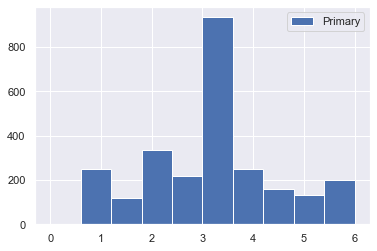

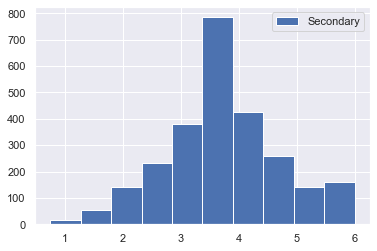

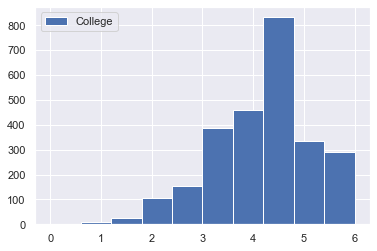

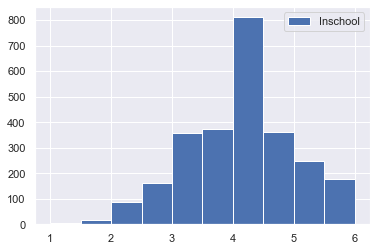

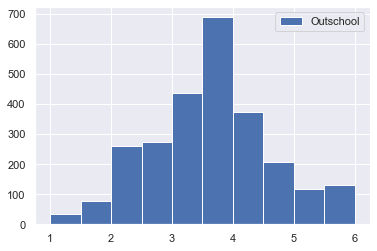

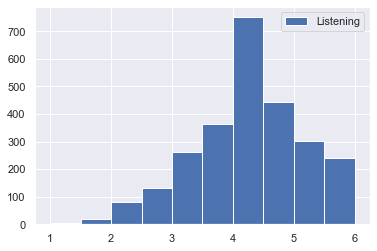

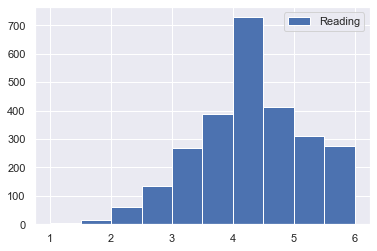

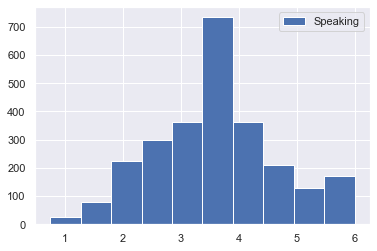

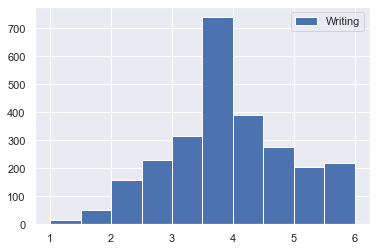

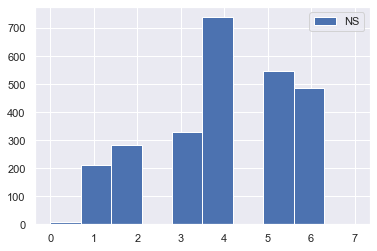

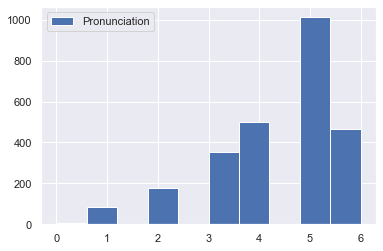

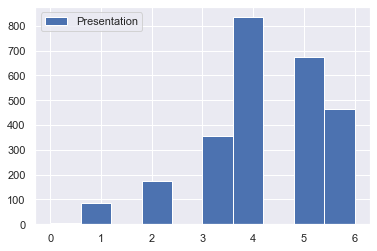

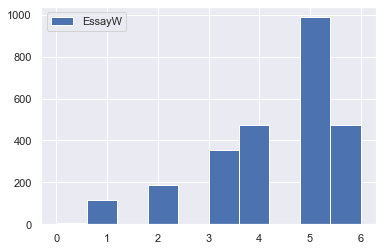

In [28]:
# Double check their distributions after fillna to make sure the distributions look reasonable.
for c in cols:
    _ = plt.hist(df[c], label=c)
    plt.legend()
    plt.show()

In [29]:
df.isna().sum()

Code                0
Country             0
PTJ1                0
SMK1                0
Sex                 0
Age                 0
Grade               0
Major               0
Field               0
Test             1101
Score            1319
VST                 0
CEFR                0
INTM                0
INSM                0
Primary             0
Secondary           0
College             0
Inschool            0
Outschool           0
Listening           0
Reading             0
Speaking            0
Writing             0
NS                  0
Pronunciation       0
Presentation        0
EssayW              0
dtype: int64

In [30]:
# Test and Score information is a jumble of information that needs to be separated out.
# Group and pull out each test as a separate column and display their unique number of entries.
for key, group in df.groupby('Test'):
    df[key] = group.Score
    print(key, ': ', df[key].nunique())

A Level (General Paper) :  0
CEE :  39
CSEPT :  4
Cambridg O Level :  0
Cambridge :  0
HKALE :  0
IELTS :  6
IEPT :  1
NAT :  1
NCAE :  1
NCAT :  0
NMET :  5
O Level (Eng Lang) :  0
ONET :  98
SAT :  1
TEPS :  17
TOEFL (PBT) :  21
TOEFL (iBT) :  26
TOEIC :  126
UPCAT :  1


In [31]:
# Most tests are too sparsely populated. Drop them.
tests_to_drop = ['A Level (General Paper)', 'CSEPT', 'Cambridg O Level',
       'Cambridge', 'HKALE', 'IELTS', 'IEPT', 'NAT', 'NCAE', 'NCAT', 'NMET',
       'O Level (Eng Lang)', 'SAT', 'TEPS', 'TOEFL (PBT)',
       'TOEFL (iBT)', 'UPCAT']
df = df.drop(tests_to_drop, axis=1)

In [32]:
tests = ['CEE', 'ONET', 'TOEIC']

for test in tests:
    df[test + '_isna'] = df[test].isna().astype(int)
    df[test] = df[test].fillna(0)

In [33]:
# Test and Score columns are now useless. Drop them.
df = df.drop(['Test', 'Score'], axis=1)

In [34]:
# Double check no more isna
df.isna().sum()

Code             0
Country          0
PTJ1             0
SMK1             0
Sex              0
Age              0
Grade            0
Major            0
Field            0
VST              0
CEFR             0
INTM             0
INSM             0
Primary          0
Secondary        0
College          0
Inschool         0
Outschool        0
Listening        0
Reading          0
Speaking         0
Writing          0
NS               0
Pronunciation    0
Presentation     0
EssayW           0
CEE              0
ONET             0
TOEIC            0
CEE_isna         0
ONET_isna        0
TOEIC_isna       0
dtype: int64

In [36]:
# Save file to csv
df.to_csv('Data/210907_Essay_score_cleaned_3.csv')